In [1]:
import os
from glob import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score,f1_score,jaccard_score,precision_score,recall_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf

from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,MaxPool2D,Conv2DTranspose,Concatenate,Input,Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import backend as K

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,ReduceLROnPlateau,EarlyStopping,TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall,Precision

## Defining layers

In [6]:
def conv_block(inputs,num_filters):
    x=Conv2D(num_filters,3,padding="same")(inputs)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    x=Conv2D(num_filters,3,padding="same")(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    return x


def encoder_block(inputs,num_filters):
    s=conv_block(inputs,num_filters)
    p=MaxPool2D((2,2))(s)
    return s,p

def decoder_block(inputs,skip_features,num_filters):
    x=Conv2DTranspose(num_filters,(2,2),strides=2,padding="same")(inputs)
    x=Concatenate()([x,skip_features])
    x=BatchNormalization()(x)                     ################
    x=Activation("relu")(x)                       ################
    x=conv_block(x,num_filters)
    return x

## CNN Architecture`

In [7]:
def build_unet(input_shape):
    inputs=Input(input_shape)    # input layer
    
    s1,p1 = encoder_block(inputs,64)     #Encoder
    s2,p2 = encoder_block(p1,128)
    s3,p3 = encoder_block(p2,256)
    s4,p4 = encoder_block(p3,512)
    
    b1 = conv_block(p4,1024)       #Bottleneck
    
    d1 = decoder_block(b1,s4,512)      #Decoder
    d2 = decoder_block(d1,s3,256)
    d3 = decoder_block(d2,s2,128)
    d4 = decoder_block(d3,s1,64)
    
    outputs = Conv2D(1,1,padding="same",activation="sigmoid")(d4)  #Output layer
    
    model = Model(inputs,outputs,name="UNET")
    return model

model=build_unet((256,256,3))
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

## Metrics

In [8]:
smooth = 1e-15
def iou(y_true,y_pred):         # converting simple function to tensor
    def f(y_true,y_pred):
        intersection = (y_true*y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f,[y_true,y_pred],tf.float32)

def dice_coef(y_true,y_pred):      # build function using tensor
    y_true = Flatten()(y_true)     # make tensor here itself
    y_pred = Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true*y_pred)
    return (2.*intersection + smooth)/(tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)+smooth)

# Using cross entropy is more of a proxy which is easier to maximize
def dice_loss(y_true,y_pred):       # perform better at class imbalanced problems
    return 1.0 - dice_coef(y_true,y_pred)

# we'll use a specialized loss function that combines binary cross entropy and our dice loss ##################
def bce_dice_loss(y_true,y_pred):
    loss=losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# Training

## visualizing mask array

In [9]:
os.getcwd()

'C:\\Users\\ashis\\OneDrive\\Documents\\summer project\\summer project - 3d\\week2'

In [10]:
def read(path1,path2):
    x = cv2.imread(path2,cv2.IMREAD_COLOR)
    y = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 1, 1)
    plt.imshow(x)

    plt.subplot(2, 1, 2)
    plt.imshow(y,cmap='gray')
    plt.show()

    
    y = cv2.resize(y, (16,16))
    return y

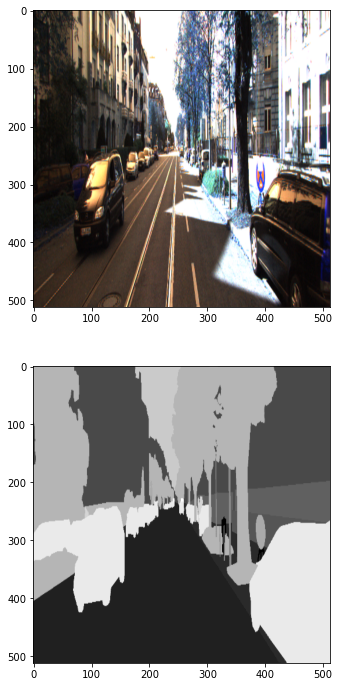

[[21 21 11 11 11 11 23 23 21 21 21 21 21 11 11 11]
 [21 21 14 11 11 11 23 23 21 21 21 21 21 11 11 11]
 [21 21 21 11 11 11 23 23 21 21 21 21 11 11 11 11]
 [21 21 21 11 11 11 23 23 21 21 21 21 11 11 11 11]
 [21 21 21 11 11 11 11 23 21 21 21 21 11 11 11 11]
 [21 21 21 11 11 11 21 23 21 21 11 21 11 11 11 11]
 [21 21 21 11 11 11 21 20 16 21 11 21 11 13 13 13]
 [21 21 21 21 21 21 18 26 26 21 13 21 13 13 13 13]
 [25 26 26 26 26 26  7  7  8 22 10 21 13 12 26 22]
 [26 26 26 26 26  7  7  7  7 21 21 21 14 26 26 26]
 [21 21 26 26 26  7  7  7  7  7  8 21 26 26 26 26]
 [21 21 26 26 24  7  7  7  7  7  8 21 26 26 26 26]
 [ 7  7 26 26  7  7  7  7  7  7  7  8 26 26 26 26]
 [ 7  7  7  7  7  7  7  7  7  7  7  7 26 26 26 26]
 [ 7  7  7  7  7  7  7  7  7  7  7  7  8 26 26 26]
 [ 7  7  7  7  7  7  7  7  7  7  7  7  7 26 26 26]]


In [11]:
img_path1='C:\\Users\\ashis\\OneDrive\\Documents\\summer project\\summer project - 3d\\week2\\new_data\\mask\\000000_10_0.png'
img_path2='C:\\Users\\ashis\\OneDrive\\Documents\\summer project\\summer project - 3d\\week2\\new_data\\image\\000000_10_0.png'
y=read(img_path1,img_path2)
print(y)

In [12]:
def read_mask1(path):
#     path = path.decode()
    y = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(y,cmap="gray")
    for i in range(len(y[:][0])):
        for j in range(len(y[0][:])):
            if y[i][j]>=25:    # Car = 2
                y[i][j]=1
#             elif y[i][j]<=10:  #Road = 0
#                 y[i][j]=0
            else:              #other = 1
                y[i][j]=0
    plt.imshow(y,cmap="gray")
    y = cv2.resize(y, (16,16))
    return y


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1]
 [1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]]


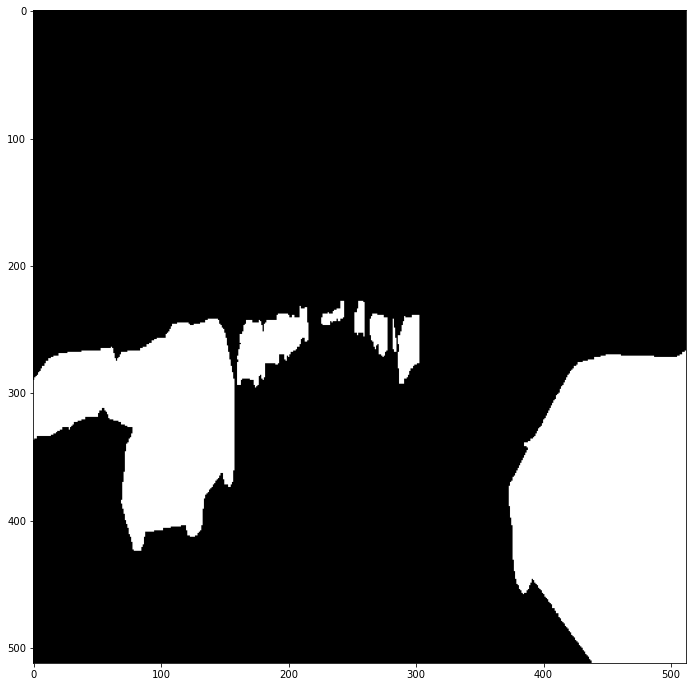

In [13]:
img_path='C:\\Users\\ashis\\OneDrive\\Documents\\summer project\\summer project - 3d\\week2\\new_data\\mask\\000000_10_0.png'
y=read_mask1(img_path)
print(y)

## Function for preprocessing

In [14]:
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x,y):
    x,y = shuffle(x,y,random_state=42)
    
def read_image(path):
    path = path.decode()
    x = cv2.imread(path,cv2.IMREAD_COLOR)
    x = cv2.resize(x,(W,H))
    x= x/255.0 
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    y = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (W, H))
    for i in range(len(y[:][0])):
        for j in range(len(y[0][:])):
            if y[i][j]>=25:    # Car = 1
                y[i][j]=1
            else:              #other = 0
                y[i][j]=0
    y = y.astype(np.float32)
    y = np.expand_dims(y, axis=-1)
    return y

def tf_parse(x_path,y_path):  # make tf tensor of image matrix
    def _parse(x_path,y_path):    # extract image
        x = read_image(x_path)
        y = read_mask(y_path)
        return x , y
    
    x,y = tf.numpy_function(_parse,[x_path,y_path],[tf.float32, tf.float32])
    x.set_shape([H,W,3])
    y.set_shape([H,W,1])
    return x,y

def tf_dataset(x_path, y_path, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x_path,y_path))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(4)
    return dataset

def load_data(path,split=0.2):
    # important
    images =sorted(glob(os.path.join(path,"image","*.png")))
    masks = sorted(glob(os.path.join(path, "mask", "*.png")))
    
    size = int(len(images)*split)
    
    train_x,valid_x = train_test_split(images,test_size=size,random_state=42)
    train_y,valid_y = train_test_split(masks, test_size=size, random_state=42)
    
    
    return (train_x, train_y), (valid_x, valid_y)

In [15]:
# seeding
np.random.seed(42)
tf.random.set_seed(42)

# directory to save files
create_dir("files_new")

# hyperparameters
batch_size =3
lr = 1e-4
num_epochs = 25
model_path ="files_new/model.h5"
csv_path="files_new/data.csv"

# Dataset
dataset_path = 'C:\\Users\\ashis\\OneDrive\\Documents\\summer project\\summer project - 3d\\week2\\new_data\\'

(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path,0.2)
train_x, train_y = shuffle(train_x, train_y)


print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")


train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

train_steps = (len(train_x)//batch_size)
valid_steps = (len(valid_x)//batch_size)

if len(train_x) % batch_size != 0:
    train_steps +=1
    
if len(valid_x) % batch_size != 0:
    valid_steps += 1
    
# train_steps=int(np.ceil(num_train_examples / float(batch_size)))

Train: 960 - 960
Valid: 240 - 240


## train model

In [16]:
model=build_unet((H,W,3))
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss=bce_dice_loss, optimizer=Adam(lr), metrics=metrics)


callbacks =[
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
]

history=model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)



Epoch 1/25
320/320 [==============================] - 204s 599ms/step - loss: 0.8904 - dice_coef: 0.3605 - iou: 0.2280 - recall: 0.6065 - precision: 0.4771 - val_loss: 1.1848 - val_dice_coef: 0.0542 - val_iou: 0.0279 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.18478, saving model to files_new\model.h5
Epoch 2/25
320/320 [==============================] - 191s 596ms/step - loss: 0.6052 - dice_coef: 0.5330 - iou: 0.3718 - recall: 0.7012 - precision: 0.6822 - val_loss: 0.8370 - val_dice_coef: 0.3294 - val_iou: 0.2046 - val_recall: 0.2818 - val_precision: 0.9410

Epoch 00002: val_loss improved from 1.18478 to 0.83703, saving model to files_new\model.h5
Epoch 3/25
320/320 [==============================] - 191s 595ms/step - loss: 0.4797 - dice_coef: 0.6303 - iou: 0.4690 - recall: 0.7415 - precision: 0.7569 - val_loss: 0.5260 - val_dice_coef: 0.5885 - val_iou: 0.4304 - val_recall: 0.5750 - val_precision: 0.8879

Epoch 00003: val_loss imp


Epoch 00025: val_loss did not improve from 0.18506


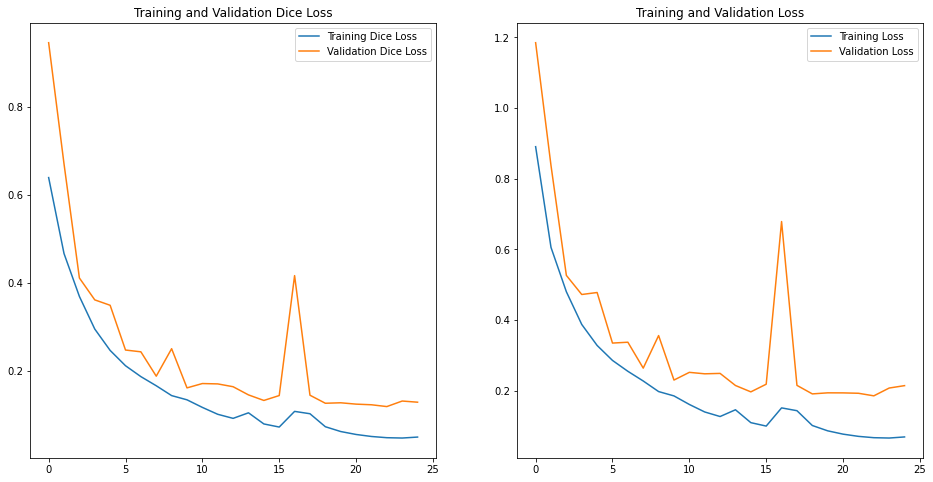

In [30]:
dice = [1.0- i for i in history.history['dice_coef']]
val_dice = [1.0- i for i in history.history['val_dice_coef']]

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [23]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 320}

In [24]:
history.history.keys()

dict_keys(['loss', 'dice_coef', 'iou', 'recall', 'precision', 'val_loss', 'val_dice_coef', 'val_iou', 'val_recall', 'val_precision', 'lr'])